In [1]:
%matplotlib inline 


import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations
from __future__ import division
import matplotlib

import sklearn.decomposition
import sklearn.metrics
from sklearn import gaussian_process
from sklearn import cross_validation

pd.options.display.mpl_style = 'default'

> Read in data from Data Preprocessing

In [2]:
# Read in data from Preprocessing results

hourlyElectricityWithFeatures = pd.read_excel('Data/hourlyElectricityWithFeatures.xlsx')
hourlyChilledWaterWithFeatures = pd.read_excel('Data/hourlyChilledWaterWithFeatures.xlsx')
hourlySteamWithFeatures = pd.read_excel('Data/hourlySteamWithFeatures.xlsx')

dailyElectricityWithFeatures = pd.read_excel('Data/dailyElectricityWithFeatures.xlsx')
dailyChilledWaterWithFeatures = pd.read_excel('Data/dailyChilledWaterWithFeatures.xlsx')
dailySteamWithFeatures = pd.read_excel('Data/dailySteamWithFeatures.xlsx')

# An example of Dataframe
dailyChilledWaterWithFeatures.head()

chilledWater-TonDays   startDay     endDay       RH-%       T-C  \
2012-01-01              0.961857 2012-01-01 2012-01-02  76.652174  7.173913   
2012-01-02              0.981725 2012-01-02 2012-01-03  55.958333  5.833333   
2012-01-03              1.003672 2012-01-03 2012-01-04  42.500000 -3.208333   
2012-01-04              1.483192 2012-01-04 2012-01-05  41.541667 -7.083333   
2012-01-05              3.465091 2012-01-05 2012-01-06  46.916667 -0.583333   

               Tdew-C  pressure-mbar  solarRadiation-W/m2  windDirection  \
2012-01-01   3.073913    1004.956522            95.260870     236.086957   
2012-01-02  -2.937500     994.625000            87.333333     253.750000   
2012-01-03 -12.975000    1002.125000            95.708333     302.916667   
2012-01-04 -16.958333    1008.250000            98.750000     286.666667   
2012-01-05  -9.866667    1002.041667            90.750000     258.333333   

            windSpeed-m/s  humidityRatio-kg/kg  coolingDegrees  \
2012-01-01       4.118361             0.004796               0   
2012-01-02       5.914357             0.003415               0   
2012-01-03       6.250005             0.001327               0   
2012-01-04       5.127319             0.000890               0   
2012-01-05       5.162041             0.001746               0   

            heatingDegrees  dehumidification  occupancy  
2012-01-01        7.826087                 0        0.0  
2012-01-02        9.166667                 0        0.3  
2012-01-03       18.208333                 0        0.3  
2012-01-04       22.083333                 0        0.3  
2012-01-05       15.583333                 0        0.3

## Daily Prediction

### Daily Electricity

> Get the training/validation and test set. The dataframe shows the features and the target.

In [3]:
def addDailyTimeFeatures(df):
    df['weekday'] = df.index.weekday
    df['day'] = df.index.dayofyear
    df['week'] = df.index.weekofyear
    return df
    

dailyElectricityWithFeatures = addDailyTimeFeatures(dailyElectricityWithFeatures)

df = dailyElectricityWithFeatures[['weekday', 'day', 'week', 'occupancy', 'electricity-kWh']]
#df.to_excel('Data/trainSet.xlsx')
trainSet = df['2012-01':'2013-06']
testSet_dailyElectricity = df['2013-07':'2014-10']

#normalizer = np.max(trainSet)
#trainSet = trainSet / normalizer
#testSet = testSet / normalizer
trainX_dailyElectricity = trainSet.values[:,0:-1]
trainY_dailyElectricity = trainSet.values[:,4]

testX_dailyElectricity = testSet_dailyElectricity.values[:,0:-1]
testY_dailyElectricity = testSet_dailyElectricity.values[:,4]

trainSet.head()

weekday  day  week  occupancy  electricity-kWh
2012-01-01        6    1    52        0.0      2800.244977
2012-01-02        0    2     1        0.3      3168.974047
2012-01-03        1    3     1        0.3      5194.533376
2012-01-04        2    4     1        0.3      5354.861935
2012-01-05        3    5     1        0.3      5496.223993

Above are the features I used in prediction for daily electricity.

> Cross validation to get input parameters

For Gaussian Processes, there are two sets of parameters to be trained. First is the theta, which are the hyperparameters in the covariance function. The second is nugget, which are the noises in the target y. In the <a href="http://www.gaussianprocess.org/gpml/code/matlab/doc/">matlab package</a>, these two sets of parameters are optimized/trained automatically. However, in the Sklearn package, you need to specify nugget. Fortunately, nugget does not affect prediction results that significantly. In both Sklearn and Matlab code package, one need to input an initial theta value. A bad value will result in local optimum. In  Matlab code package, the prediction results are not very sensitive to the initial values of theta. However, in Sklearn, the prediction results <b>ARE SENSITIVE</b> to the initial values of theta. Therefore, one has to input a good initial theta value. I use cross validation on the training set to get the best initial values for theta and the value of nugget. I compared the prediction results (see hourly electricity prediction) with Matlab.

The input data are normalized with in the sklearn GP module. Therefore, no need to normalize input data beforehanded.

There are actually some behind-scence tests. I first do a coarse grid serach for parameters, which is not shown here. After that, I am able to get the range of parameters for fine grid search as shown below. 

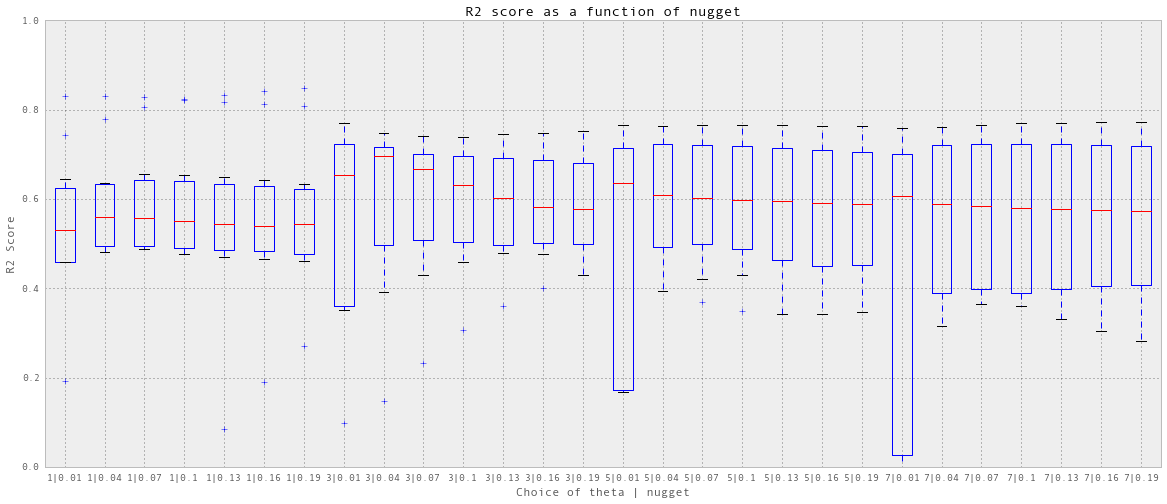

In [99]:
def crossValidation_all(theta, nugget, nfold, trainX, trainY):
    
    thetaU = theta * 2
    thetaL = theta/2
    
    scores = np.zeros((len(nugget) * len(theta), nfold))
    labels = ["" for x in range(len(nugget) * len(theta))]

    k = 0
    for j in range(len(theta)):
        for i in range(len(nugget)):
            gp = gaussian_process.GaussianProcess(theta0 = theta[j], nugget = nugget[i])
            scores[k, :] = cross_validation.cross_val_score(gp, trainX, trainY, scoring='r2', cv = nfold)  
            labels[k] = str(theta[j]) + '|' + str(nugget[i])  
            k = k + 1
    
    plt.figure(figsize=(20,8))
    plt.boxplot(scores.T, sym='b+', labels = labels, whis = 0.5)
    plt.ylim([0,1])
    plt.title('R2 score as a function of nugget')
    plt.ylabel('R2 Score')
    plt.xlabel('Choice of theta | nugget')
    plt.show()
    
    
theta = np.arange(1, 8, 2)
nfold = 10
nugget = np.arange(0.01, 0.2, 0.03)

crossValidation_all(theta, nugget, nfold, trainX_dailyElectricity, trainY_dailyElectricity)



I choose theta = 3 and nuggest = 0.04, which gives the best median prediction accuracy.

> Predict, calculate accuracy and visualize

Train score R2: 0.922109831389
Test score R2: 0.822408541698


/Users/byan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


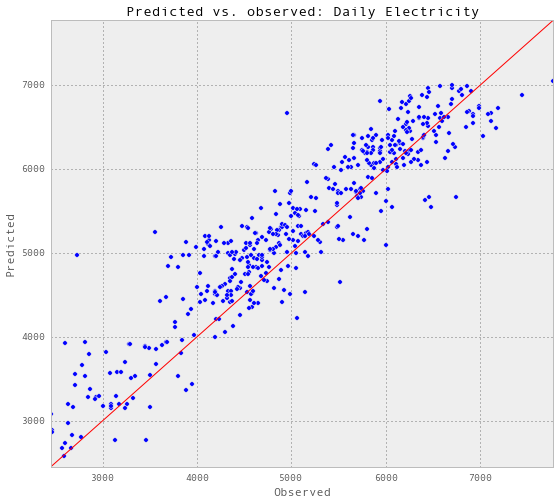

In [4]:
def predictAll(theta, nugget, trainX, trainY, testX, testY, testSet, title):

    gp = gaussian_process.GaussianProcess(theta0=theta, nugget =nugget)
    gp.fit(trainX, trainY)

    predictedY, MSE = gp.predict(testX, eval_MSE = True)
    sigma = np.sqrt(MSE)

    results = testSet.copy()
    results['predicted'] = predictedY
    results['measured'] = testY
    results['sigma'] = sigma

    print("Train score R2:", gp.score(trainX, trainY))
    print("Test score R2:", sklearn.metrics.r2_score(testY, predictedY)) 

    plt.figure(figsize = (9,8))
    plt.scatter(testY, predictedY)
    plt.plot([min(testY), max(testY)], [min(testY), max(testY)], 'r')
    plt.xlim([min(testY), max(testY)])
    plt.ylim([min(testY), max(testY)])
    plt.title('Predicted vs. observed: ' + title)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.show()
    
    return gp, results

gp_dailyElectricity, results_dailyElectricity = predictAll(3, 0.04, trainX_dailyElectricity, trainY_dailyElectricity, 
                                  testX_dailyElectricity, testY_dailyElectricity, testSet_dailyElectricity, 'Daily Electricity')

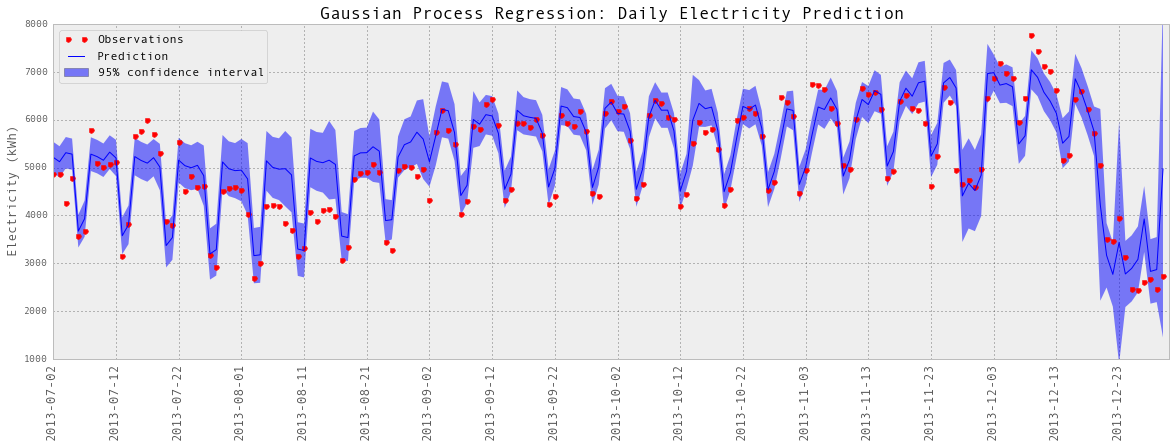

In [5]:
def plotGP(testY, predictedY, sigma):
    fig = plt.figure(figsize = (20,6))
    plt.plot(testY, 'r.', markersize=10, label=u'Observations')
    plt.plot(predictedY, 'b-', label=u'Prediction')
    x = range(len(testY))
    plt.fill(np.concatenate([x, x[::-1]]), np.concatenate([predictedY - 1.9600 * sigma, (predictedY + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')

    
subset = results_dailyElectricity['2013-07':'2013-12']
testY = subset['electricity-kWh']
predictedY = subset['predicted']
sigma = subset['sigma']

plotGP(testY, predictedY, sigma)

plt.ylabel('Electricity (kWh)', fontsize = 13)
plt.title('Gaussian Process Regression: Daily Electricity Prediction', fontsize = 17)
plt.legend(loc='upper left')
plt.xlim([0, len(testY)])
plt.ylim([1000,8000])

xTickLabels = pd.DataFrame(data = subset.index[np.arange(0,len(subset.index),10)], columns=['datetime'])
xTickLabels['date'] = xTickLabels['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
ax = plt.gca()
ax.set_xticks(np.arange(0, len(subset), 10))
ax.set_xticklabels(labels = xTickLabels['date'], fontsize = 13, rotation = 90)
plt.show()

In [8]:
import json

def exportJson(results, filename):
    columns = ['predicted','measured', 'sigma']
    export = results.loc[:, columns]

    for column in columns:
        export[column] = export[column].apply(lambda x: '%.1f' % x)

        export['date'] = export.index
    export['date'] = export['date'].map(lambda x: str(x))
    export = export.to_dict(orient = 'record')

    file = open('visualization/test/' + filename,"w")
    json.dump(export, file, indent=4)
    file.close()
    
exportJson(subset, 'electricity.json')

In [86]:
def fakeProbability(x):
    xmin = min(x)
    xmax = max(x)
    a = 0.45 / (xmax - xmin)
    b = 0.5 - a * xmin

    return a*x + b

def processResults(results, threshold = 2):

    delta_sigma = (results['measured'] - results['predicted'])/results['sigma']
    delta_sigma[delta_sigma <= threshold] = 0
#     plt.figure(figsize = (20,6))
#     plt.plot(delta_sigma, 'o')
#     xTickLabels = pd.DataFrame(data = results.index[np.arange(0,len(results),10)], columns=['datetime'])
#     xTickLabels['date'] = xTickLabels['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
#     ax = plt.gca()
#     ax.set_xticks(np.arange(0, len(results), 10))
#     ax.set_xticklabels(labels = xTickLabels['date'], fontsize = 13, rotation = 90)
#     plt.show()
    results['delta_sigma'] = delta_sigma
    results['prob'] = fakeProbability(delta_sigma)
    results['probability of abnormality'] = pd.Series(["{0:.0f}%".format(val*100) for val in results['prob']], 
                                                      index = results.index)
    return results

results = processResults(results_dailyElectricity)
results.loc[results['delta_sigma']>=3,['probability of abnormality']]


probability of abnormality
2013-07-16                        74%
2013-07-17                        86%
2013-10-28                        88%
2013-11-04                        95%
2013-12-08                        79%
2013-12-09                        77%
2013-12-12                        75%
2014-03-02                        84%
2014-03-13                        79%
2014-10-20                        79%

In [21]:
testX_dailyElectricity

array([[   1. ,  183. ,   27. ,    0.5],
       [   2. ,  184. ,   27. ,    0.5],
       [   3. ,  185. ,   27. ,    0.5],
       ..., 
       [   1. ,  301. ,   44. ,    1. ],
       [   2. ,  302. ,   44. ,    1. ],
       [   3. ,  303. ,   44. ,    1. ]])

### Daily Chilled Water 

> Get the training/validation and test set. The dataframe shows the features and the target.

In [9]:
dailyChilledWaterWithFeatures = addDailyTimeFeatures(dailyChilledWaterWithFeatures)

df = dailyChilledWaterWithFeatures[['weekday', 'day', 'week', 'occupancy', 'coolingDegrees', 'T-C', 
                                    'humidityRatio-kg/kg', 'dehumidification', 'chilledWater-TonDays']]
#df.to_excel('Data/trainSet.xlsx')
trainSet = df['2012-01':'2013-06']
testSet_dailyChilledWater = df['2013-07':'2014-10']

trainX_dailyChilledWater = trainSet.values[:,0:-1]
trainY_dailyChilledWater = trainSet.values[:,8]

testX_dailyChilledWater = testSet_dailyChilledWater.values[:,0:-1]
testY_dailyChilledWater = testSet_dailyChilledWater.values[:,8]

trainSet.head()

weekday  day  week  occupancy  coolingDegrees       T-C  \
2012-01-01        6    1    52        0.0               0  7.173913   
2012-01-02        0    2     1        0.3               0  5.833333   
2012-01-03        1    3     1        0.3               0 -3.208333   
2012-01-04        2    4     1        0.3               0 -7.083333   
2012-01-05        3    5     1        0.3               0 -0.583333   

            humidityRatio-kg/kg  dehumidification  chilledWater-TonDays  
2012-01-01             0.004796                 0              0.961857  
2012-01-02             0.003415                 0              0.981725  
2012-01-03             0.001327                 0              1.003672  
2012-01-04             0.000890                 0              1.483192  
2012-01-05             0.001746                 0              3.465091

> Above are the features used in daily chilled water prediction.

Again, need cross validation for chilled water.

> Cross validation to get input parameters

In [ ]:
def crossValidation(theta, nugget, nfold, trainX, trainY):
    
    scores = np.zeros((len(theta), nfold))

    for i in range(len(theta)):
        gp = gaussian_process.GaussianProcess(theta0 = theta[i], thetaU = 10, thetaL = 0.1, nugget = nugget)
        scores[i, :] = cross_validation.cross_val_score(gp, trainX, trainY, scoring='r2', cv = nfold)

    plt.boxplot(scores.T, sym='b+', labels = theta, whis = 0.5)
    #plt.ylim(ylim)
    plt.title('R2 score as a function of theta0')
    plt.ylabel('R2 Score')
    plt.xlabel('Choice of theta0')
    plt.show()

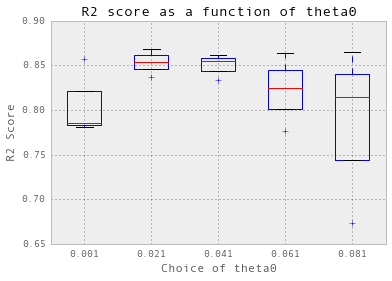

In [10]:
theta = np.arange(0.001, 0.1, 0.02)
nugget = 0.05
crossValidation(theta, nugget, 3, trainX_dailyChilledWater, trainY_dailyChilledWater)

The cross validation actually does not work very well for chilled water. First, I have to use a three-fold cross validation instead of ten. In addition, in order to simply the process, from now on, I only show the cross validation results against initial values of theta: theta0. I did the search for nugget behind the scene.

> Predict, calculate accuracy and visualize

Train score R2: 0.91483040513
Test score R2: 0.901408621289


/Users/byan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


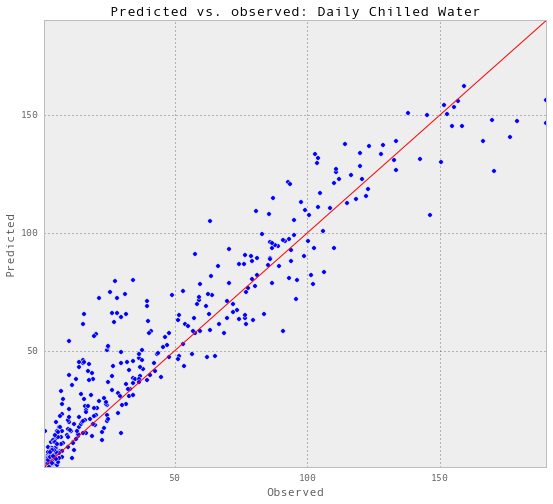

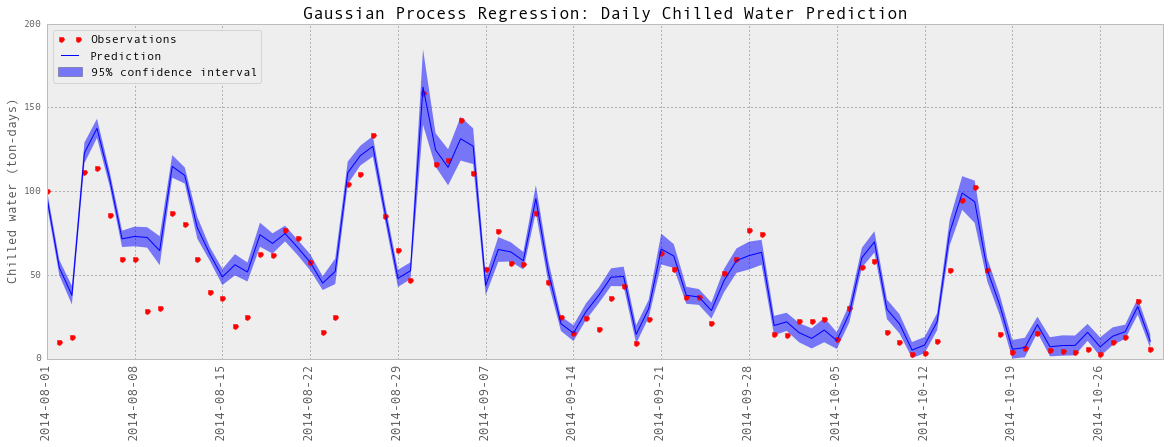

In [11]:
theta = 0.021
nugget =0.05

# Predict
gp, results_dailyChilledWater = predictAll(theta, nugget, trainX_dailyChilledWater, trainY_dailyChilledWater, 
                                           testX_dailyChilledWater, testY_dailyChilledWater, testSet_dailyChilledWater, 
                                           'Daily Chilled Water')

# Visualize
subset = results_dailyChilledWater['2014-08':'2014-10']
testY = subset['chilledWater-TonDays']
predictedY = subset['predicted']
sigma = subset['sigma']
    
plotGP(testY, predictedY, sigma)

plt.ylabel('Chilled water (ton-days)', fontsize = 13)
plt.title('Gaussian Process Regression: Daily Chilled Water Prediction', fontsize = 17)
plt.legend(loc='upper left')
plt.xlim([0, len(testY)])
#plt.ylim([1000,8000])

xTickLabels = pd.DataFrame(data = subset.index[np.arange(0,len(subset.index),7)], columns=['datetime'])
xTickLabels['date'] = xTickLabels['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
ax = plt.gca()
ax.set_xticks(np.arange(0, len(subset), 7))
ax.set_xticklabels(labels = xTickLabels['date'], fontsize = 13, rotation = 90)
plt.show()

Quite successful again.

#### Add One More Feature: Prediction of Electricity

In order to improve prediction accuracy, I add one more feature, prediction of electricity consumption. Predicted electricity is generated based on time features as described above in the electricity section. This describes the occupancy schedule. Needs actual electricity consumption in the training data set for training, then predict electricity consumption as a feature for the test data set. Therefore, this predicting method still only requires time and weather information and historical energy consumption to predict future energy consumption

In [12]:
dailyChilledWaterWithFeatures['predictedElectricity'] = gp_dailyElectricity.predict(
                                                            dailyChilledWaterWithFeatures[['weekday', 'day', 'week', 'occupancy']].values)


df = dailyChilledWaterWithFeatures[['weekday', 'day', 'week', 'occupancy', 'coolingDegrees', 'T-C', 
                                    'humidityRatio-kg/kg', 'dehumidification', 'predictedElectricity', 'chilledWater-TonDays']]
#df.to_excel('Data/trainSet.xlsx')
trainSet = df['2012-01':'2013-06']
testSet_dailyChilledWaterMoreFeatures = df['2013-07':'2014-10']

trainX_dailyChilledWaterMoreFeatures = trainSet.values[:,0:-1]
trainY_dailyChilledWaterMoreFeatures = trainSet.values[:,9]

testX_dailyChilledWaterMoreFeatures = testSet_dailyChilledWaterMoreFeatures.values[:,0:-1]
testY_dailyChilledWaterMoreFeatures = testSet_dailyChilledWaterMoreFeatures.values[:,9]

trainSet.head()

weekday  day  week  occupancy  coolingDegrees       T-C  \
2012-01-01        6    1    52        0.0               0  7.173913   
2012-01-02        0    2     1        0.3               0  5.833333   
2012-01-03        1    3     1        0.3               0 -3.208333   
2012-01-04        2    4     1        0.3               0 -7.083333   
2012-01-05        3    5     1        0.3               0 -0.583333   

            humidityRatio-kg/kg  dehumidification  predictedElectricity  \
2012-01-01             0.004796                 0           2883.784617   
2012-01-02             0.003415                 0           4231.128909   
2012-01-03             0.001327                 0           5013.703046   
2012-01-04             0.000890                 0           4985.929899   
2012-01-05             0.001746                 0           5106.976841   

            chilledWater-TonDays  
2012-01-01              0.961857  
2012-01-02              0.981725  
2012-01-03              1.003672  
2012-01-04              1.483192  
2012-01-05              3.465091

> Cross validation

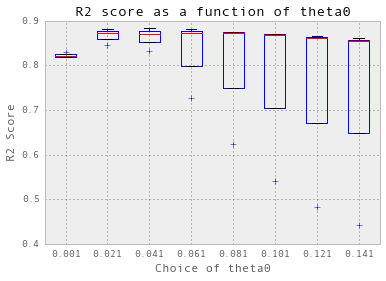

In [19]:
theta = np.arange(0.001, 0.15, 0.02)
nugget = 0.05
crossValidation(theta, nugget, 3, trainX_dailyChilledWaterMoreFeatures, trainY_dailyChilledWaterMoreFeatures)

> Predict, calculate accuracy and visualize

Train score R2: 0.937952834542
Test score R2: 0.926978705167


/Users/byan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


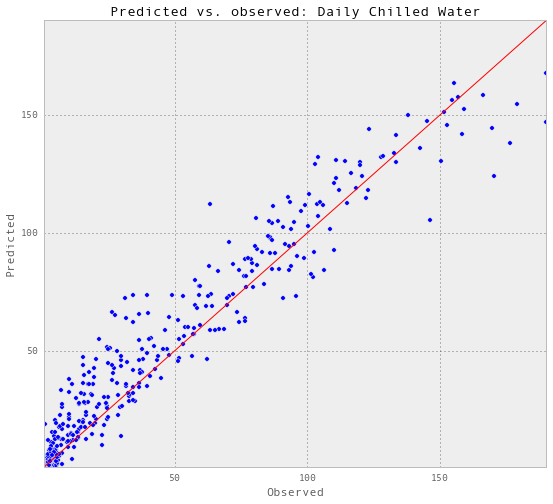

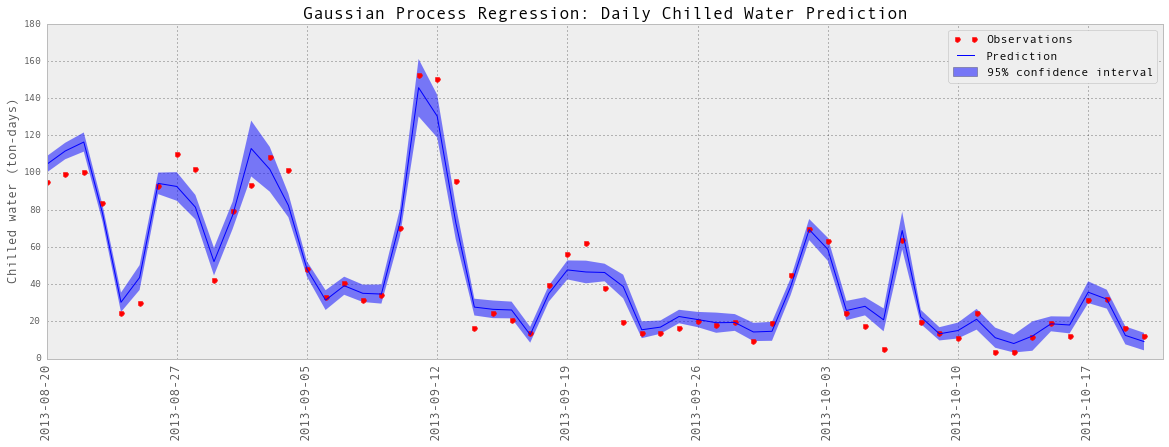

In [21]:
# Predict
gp, results_dailyChilledWaterMoreFeatures = predictAll(0.021, 0.05, 
                trainX_dailyChilledWaterMoreFeatures, trainY_dailyChilledWaterMoreFeatures, 
                testX_dailyChilledWaterMoreFeatures, testY_dailyChilledWaterMoreFeatures,
                testSet_dailyChilledWaterMoreFeatures, 'Daily Chilled Water')

# Visualize
subset = results_dailyChilledWaterMoreFeatures['2013-08-20':'2013-10-20']
testY = subset['chilledWater-TonDays']
predictedY = subset['predicted']
sigma = subset['sigma']
    
plotGP(testY, predictedY, sigma)

plt.ylabel('Chilled water (ton-days)', fontsize = 13)
plt.title('Gaussian Process Regression: Daily Chilled Water Prediction', fontsize = 17)
plt.legend(loc='upper right')
plt.xlim([0, len(testY)])
#plt.ylim([1000,8000])

xTickLabels = pd.DataFrame(data = subset.index[np.arange(0,len(subset.index),7)], columns=['datetime'])
xTickLabels['date'] = xTickLabels['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
ax = plt.gca()
ax.set_xticks(np.arange(0, len(subset), 7))
ax.set_xticklabels(labels = xTickLabels['date'], fontsize = 13, rotation = 90)
plt.show()

In [15]:
exportJson(subset, 'chilledWater.json')

The accuracy does improve a little, according to the R2 score.

In [80]:
results = processResults(results_dailyChilledWaterMoreFeatures)
results.loc[results['delta_sigma']>=3,['probability of abnormality']]

probability of abnormality
2013-07-08                        71%
2013-07-09                        69%
2013-07-12                        75%
2013-07-15                        68%
2013-07-16                        95%
2013-07-17                        90%
2013-07-18                        64%
2013-07-19                        59%
2013-07-21                        63%
2013-07-22                        83%
2013-07-24                        61%
2013-08-01                        64%
2013-08-06                        59%
2013-08-07                        59%
2013-08-27                        63%
2013-08-28                        68%
2013-09-04                        67%
2013-09-12                        60%
2013-09-13                        64%
2013-09-19                        60%
2013-09-20                        65%
2013-10-21                        65%
2014-06-20                        60%
2014-07-21                        62%
2014-09-08                        62%
2014-09-29                        60%
2014-10-02                        59%
2014-10-03                        63%

### Daily Steam

> Get the training/validation and test set. The dataframe shows the features and the target.

In [16]:
dailySteamWithFeatures = addDailyTimeFeatures(dailySteamWithFeatures)

dailySteamWithFeatures['predictedElectricity'] = gp_dailyElectricity.predict(
                                                            dailySteamWithFeatures[['weekday', 'day', 'week', 'occupancy']].values)


df = dailySteamWithFeatures[['weekday', 'day', 'week', 'occupancy', 'heatingDegrees', 'T-C', 
                                    'humidityRatio-kg/kg', 'predictedElectricity', 'steam-LBS']]
#df.to_excel('Data/trainSet.xlsx')
trainSet = df['2012-01':'2013-06']
testSet_dailySteam = df['2013-07':'2014-10']

trainX_dailySteam = trainSet.values[:,0:-1]
trainY_dailySteam = trainSet.values[:,8]

testX_dailySteam = testSet_dailySteam.values[:,0:-1]
testY_dailySteam = testSet_dailySteam.values[:,8]

trainSet.head()

weekday  day  week  occupancy  heatingDegrees       T-C  \
2012-01-01        6    1    52        0.0        7.826087  7.173913   
2012-01-02        0    2     1        0.3        9.166667  5.833333   
2012-01-03        1    3     1        0.3       18.208333 -3.208333   
2012-01-04        2    4     1        0.3       22.083333 -7.083333   
2012-01-05        3    5     1        0.3       15.583333 -0.583333   

            humidityRatio-kg/kg  predictedElectricity     steam-LBS  
2012-01-01             0.004796           2883.784617  17256.468099  
2012-01-02             0.003415           4231.128909  17078.440755  
2012-01-03             0.001327           5013.703046  59997.969401  
2012-01-04             0.000890           4985.929899  56104.878906  
2012-01-05             0.001746           5106.976841  45231.708984

> Cross validation to get input parameters

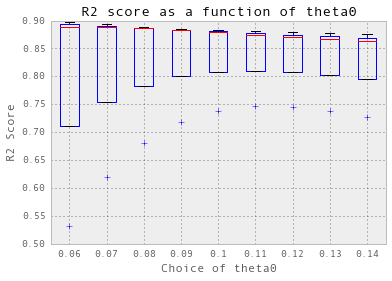

In [22]:
theta = np.arange(0.06, 0.15, 0.01)
nugget = 0.05
crossValidation(theta, nugget, 3, trainX_dailySteam, trainY_dailySteam)

> Predict, calculate accuracy and visualize

Train score R2: 0.96729657748
Test score R2: 0.933120481633


/Users/byan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


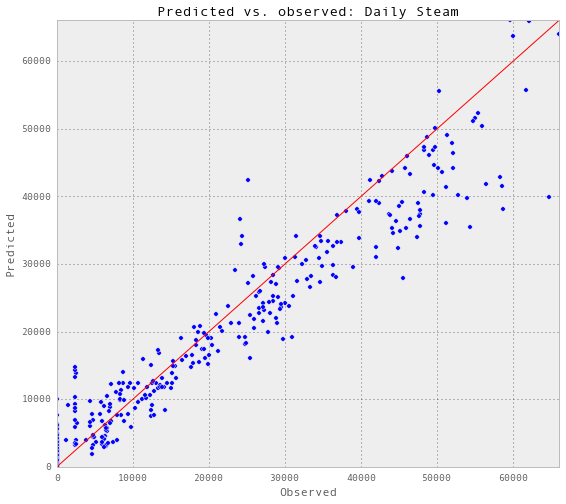

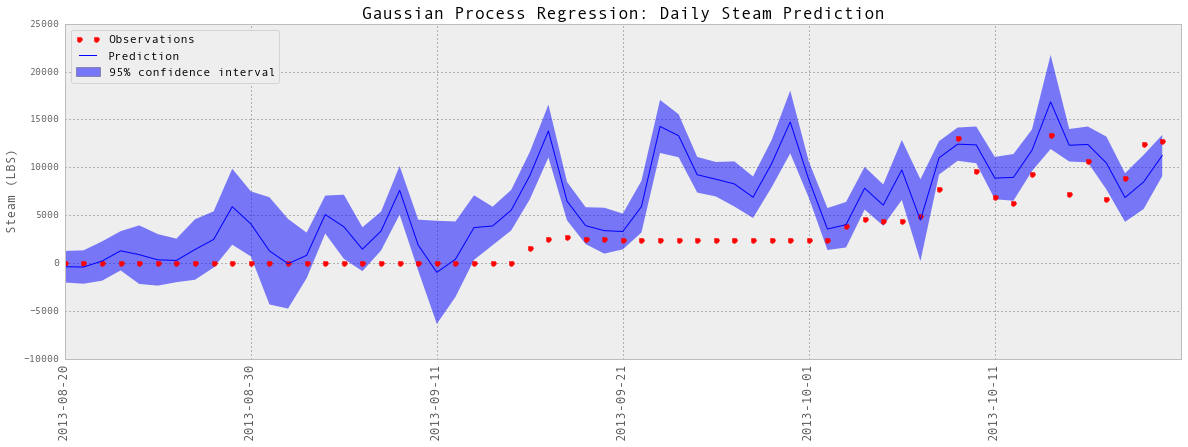

In [20]:
# Predict
gp, results_dailySteam = predictAll(0.1, 0.05, trainX_dailySteam, trainY_dailySteam, 
                                    testX_dailySteam, testY_dailySteam, testSet_dailySteam, 'Daily Steam')

# Visualize
subset = results_dailySteam['2013-08-20':'2013-10-20']
testY = subset['steam-LBS']
predictedY = subset['predicted']
sigma = subset['sigma']
    
plotGP(testY, predictedY, sigma)

plt.ylabel('Steam (LBS)', fontsize = 13)
plt.title('Gaussian Process Regression: Daily Steam Prediction', fontsize = 17)
plt.legend(loc='upper left')
plt.xlim([0, len(testY)])
#plt.ylim([1000,8000])

xTickLabels = pd.DataFrame(data = subset.index[np.arange(0,len(subset.index),10)], columns=['datetime'])
xTickLabels['date'] = xTickLabels['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
ax = plt.gca()
ax.set_xticks(np.arange(0, len(subset), 10))
ax.set_xticklabels(labels = xTickLabels['date'], fontsize = 13, rotation = 90)
plt.show()

In [19]:
exportJson(subset, 'steam.json')

In [91]:
results = processResults(results_dailySteam, threshold = 3.5)
results.loc[results['delta_sigma']>=4.5,['probability of abnormality']]

probability of abnormality
2013-11-05                        60%
2013-11-08                        62%
2013-11-12                        70%
2013-11-13                        60%
2013-11-14                        61%
2013-11-16                        62%
2013-11-26                        65%
2013-12-09                        62%
2013-12-15                        65%
2014-01-25                        63%
2014-01-26                        61%
2014-01-27                        70%
2014-02-01                        60%
2014-02-08                        64%
2014-02-09                        71%
2014-02-13                        68%
2014-02-14                        66%
2014-02-15                        76%
2014-02-16                        76%
2014-02-18                        60%
2014-02-22                        61%
2014-03-02                        95%
2014-03-08                        60%
2014-03-15                        62%
2014-03-16                        62%
2014-03-20                        60%
2014-03-21                        62%
2014-03-23                        60%
2014-03-26                        63%
2014-03-27                        65%
2014-03-28                        64%
2014-03-29                        70%
2014-03-30                        70%
2014-03-31                        68%
2014-04-01                        67%
2014-04-02                        69%
2014-04-03                        66%
2014-04-05                        67%
2014-04-23                        64%

## Hourly Prediction

I used the same method to train and test hourly models. Because as the number of data points increases, the computational cost increases significantly. Cross validation on a large data set is not possible as we do not have a lot of time for project. Therefore, I only use a small set of training/validation data to get the parameters and then train and test using the complete data set, and let my computer run overnight.

### Hourly Electricity

> Get the training/validation and test set. The dataframe shows the features and the target.

In [22]:
def addHourlyTimeFeatures(df):
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    df['day'] = df.index.dayofyear
    df['week'] = df.index.weekofyear
    
    return df

hourlyElectricityWithFeatures = addHourlyTimeFeatures(hourlyElectricityWithFeatures)

df_hourlyElectricity = hourlyElectricityWithFeatures[['hour', 'weekday', 'day', 'week', 'cosHour', 
                                                      'occupancy', 'electricity-kWh']]
#df_hourlyElectricity.to_excel('Data/trainSet_hourlyElectricity.xlsx')

def setTrainTestSets(df, trainStart, trainEnd, testStart, testEnd, indY):
    
    trainSet = df[trainStart : trainEnd]
    testSet = df[testStart : testEnd]

    trainX = trainSet.values[:,0:-1]
    trainY = trainSet.values[:,indY]

    testX = testSet.values[:,0:-1]
    testY = testSet.values[:,indY]
    
    return trainX, trainY, testX, testY, testSet


trainStart = '2013-02'
trainEnd = '2013-05'
testStart = '2014-03'
testEnd = '2014-04'

df = df_hourlyElectricity;

trainX_hourlyElectricity, trainY_hourlyElectricity, testX_hourlyElectricity, testY_hourlyElectricity, \
    testSet_hourlyElectricity = setTrainTestSets(df, trainStart, trainEnd, testStart, testEnd, 6) 


df_hourlyElectricity.head()

hour  weekday  day  week   cosHour  occupancy  \
2012-01-01 01:00:00     1        6    1    52  0.866025          0   
2012-01-01 02:00:00     2        6    1    52  0.965926          0   
2012-01-01 03:00:00     3        6    1    52  1.000000          0   
2012-01-01 04:00:00     4        6    1    52  0.965926          0   
2012-01-01 05:00:00     5        6    1    52  0.866025          0   

                     electricity-kWh  
2012-01-01 01:00:00       111.479277  
2012-01-01 02:00:00       117.989395  
2012-01-01 03:00:00       119.010131  
2012-01-01 04:00:00       116.005587  
2012-01-01 05:00:00       111.132977

> Cross validation to get input parameters

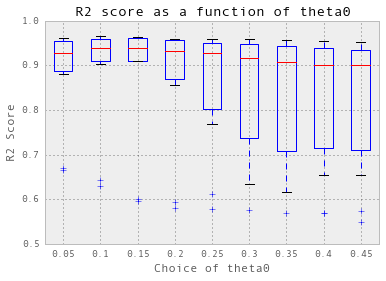

In [108]:
nugget = 0.008
theta = np.arange(0.05, 0.5, 0.05)
crossValidation(theta, nugget, 10, trainX_hourlyElectricity, trainY_hourlyElectricity)

> Predict, calculate accuracy and visualize

Train score R2: 0.965480717537
Test score R2: 0.896032979093


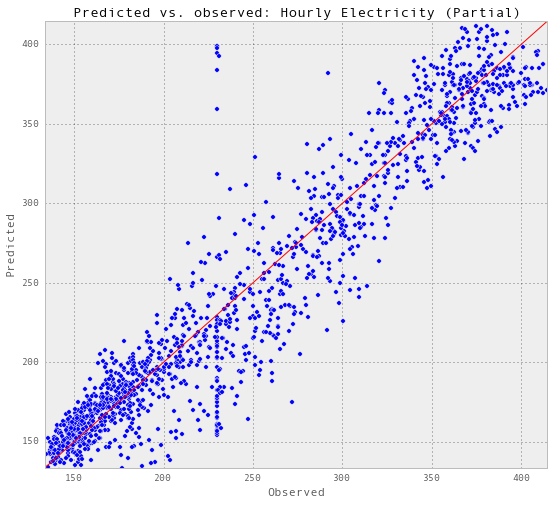

In [24]:
gp_hourlyElectricity, results_hourlyElectricity = predictAll(0.15, 0.008, trainX_hourlyElectricity, trainY_hourlyElectricity, 
                                  testX_hourlyElectricity, testY_hourlyElectricity, testSet_hourlyElectricity, 
                                  'Hourly Electricity (Partial)')

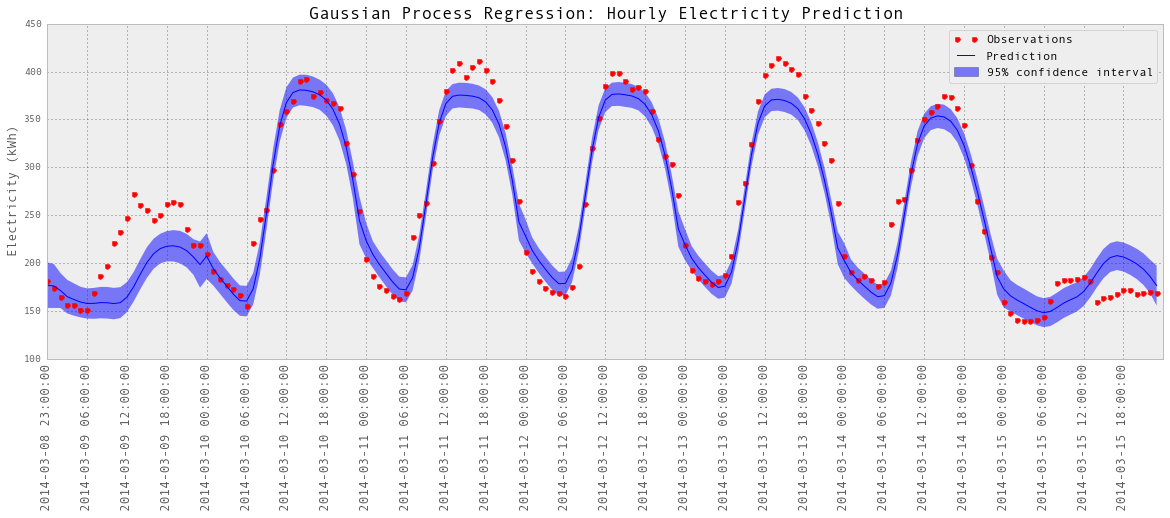

In [211]:
subset = results_hourlyElectricity['2014-03-08 23:00:00':'2014-03-15']
testY = subset['electricity-kWh']
predictedY = subset['predictedY']
sigma = subset['sigma']

plotGP(testY, predictedY, sigma)

plt.ylabel('Electricity (kWh)', fontsize = 13)
plt.title('Gaussian Process Regression: Hourly Electricity Prediction', fontsize = 17)
plt.legend(loc='upper right')
plt.xlim([0, len(testY)])
#plt.ylim([1000,8000])

xTickLabels = subset.index[np.arange(0,len(subset.index),6)]
ax = plt.gca()
ax.set_xticks(np.arange(0, len(subset), 6))
ax.set_xticklabels(labels = xTickLabels, fontsize = 13, rotation = 90)
plt.show()

I compared the results with Matlab code output. 

Figure: Matlab output for hourly electricity predcition.
<img src = "Pics/results_hourlyElectricity.png", style="width:100%">


#### Train and Test for all hourly data

> Final prediction accuracy for hourly electricity.


Test score R2: 0.882986662109


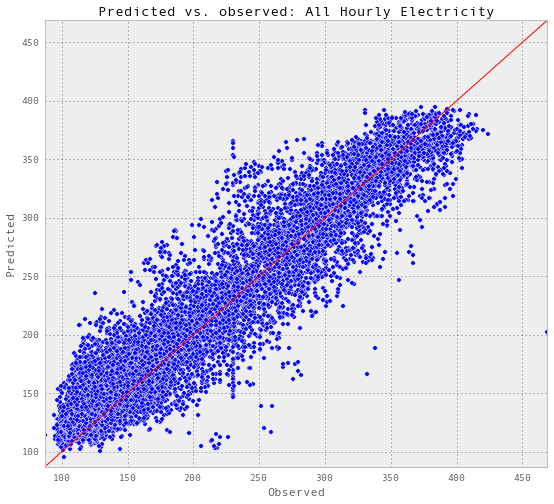

In [25]:
trainStart = '2012-01'
trainEnd = '2013-06'
testStart = '2013-07'
testEnd = '2014-10'

results_allHourlyElectricity = pd.read_excel('Data/results_allHourlyElectricity.xlsx')

def plotR2(df, energyType, title):
    testY = df[energyType]
    predictedY = df['predictedY']
    
    print "Test score R2:", sklearn.metrics.r2_score(testY, predictedY)

    plt.figure(figsize = (9,8))
    plt.scatter(testY, predictedY)
    plt.plot([min(testY), max(testY)], [min(testY), max(testY)], 'r')
    plt.xlim([min(testY), max(testY)])
    plt.ylim([min(testY), max(testY)])
    plt.title('Predicted vs. observed: ' + title)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.show()

plotR2(results_allHourlyElectricity, 'electricity-kWh', 'All Hourly Electricity')

### Hourly Chilled Water

> Get the training/validation and test set. The dataframe shows the features and the target.

In [26]:
trainStart = '2013-08'
trainEnd = '2013-10'
testStart = '2014-08'
testEnd = '2014-10'

def getPredictedElectricity(trainStart, trainEnd, testStart, testEnd):
    trainX, trainY, testX, testY, testSet = setTrainTestSets(df_hourlyElectricity, trainStart, trainEnd, testStart, testEnd, 6) 
    
    gp = gaussian_process.GaussianProcess(theta0 = 0.15, nugget = 0.008)
    gp.fit(trainX, trainY)

    trainSet = df_hourlyElectricity[trainStart : trainEnd]
    predictedElectricity = pd.DataFrame(data = np.zeros(len(trainSet)), index = trainSet.index, columns = ['predictedElectricity'])
    predictedElectricity = predictedElectricity.append(pd.DataFrame(data = np.zeros(len(testSet)), index = testSet.index, 
                                                   columns = ['predictedElectricity']))

    predictedElectricity.loc[trainStart:trainEnd, 'predictedElectricity'] = gp.predict(trainX) 
    predictedElectricity.loc[testStart:testEnd, 'predictedElectricity'] = gp.predict(testX)
    
    return predictedElectricity

predictedElectricity = getPredictedElectricity(trainStart, trainEnd, testStart, testEnd)   
    
hourlyChilledWaterWithMoreFeatures = hourlyChilledWaterWithFeatures.join(predictedElectricity, how = 'inner')

hourlyChilledWaterWithMoreFeatures = addHourlyTimeFeatures(hourlyChilledWaterWithMoreFeatures)

df_hourlyChilledWater = hourlyChilledWaterWithMoreFeatures[['hour', 'cosHour', 'weekday', 'day', 'week', 'occupancy', 'T-C', 
                                                        'humidityRatio-kg/kg', 'predictedElectricity', 'chilledWater-TonDays']]


df = df_hourlyChilledWater;

trainX_hourlyChilledWater, trainY_hourlyChilledWater, testX_hourlyChilledWater, testY_hourlyChilledWater, \
    testSet_hourlyChilledWater = setTrainTestSets(df, trainStart, trainEnd, testStart, testEnd, 9) 


df_hourlyChilledWater.head()

hour   cosHour  weekday  day  week  occupancy   T-C  \
2013-08-01 00:00:00     0  0.707107        3  213    31        0.5  17.7   
2013-08-01 01:00:00     1  0.866025        3  213    31        0.5  17.8   
2013-08-01 02:00:00     2  0.965926        3  213    31        0.5  17.7   
2013-08-01 03:00:00     3  1.000000        3  213    31        0.5  17.6   
2013-08-01 04:00:00     4  0.965926        3  213    31        0.5  17.7   

                     humidityRatio-kg/kg  predictedElectricity  \
2013-08-01 00:00:00             0.010765            123.431454   
2013-08-01 01:00:00             0.012102            119.266616   
2013-08-01 02:00:00             0.012026            121.821887   
2013-08-01 03:00:00             0.011962            124.888675   
2013-08-01 04:00:00             0.011912            124.824413   

                     chilledWater-TonDays  
2013-08-01 00:00:00              0.200647  
2013-08-01 01:00:00              0.183318  
2013-08-01 02:00:00              0.183318  
2013-08-01 03:00:00              0.183318  
2013-08-01 04:00:00              0.183318

> Cross validation to get input parameters

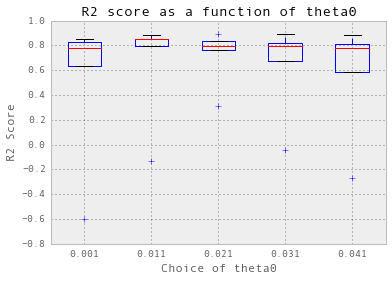

In [190]:
nugget = 0.01
theta = np.arange(0.001, 0.05, 0.01)
crossValidation(theta, nugget, 5, trainX_hourlyChilledWater, trainY_hourlyChilledWater)

> Predict, calculate accuracy and visualize

Train score R2: 0.914352370778
Test score R2: 0.865202975683


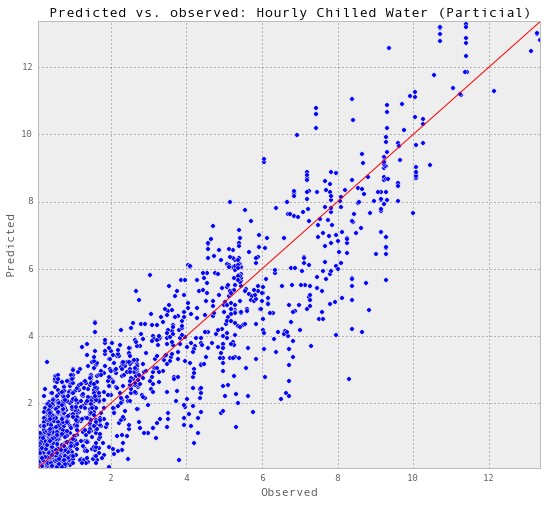

In [31]:
gp_hourlyChilledWater, results_hourlyChilledWater = predictAll(0.011, 0.01, trainX_hourlyChilledWater, trainY_hourlyChilledWater, 
                                  testX_hourlyChilledWater, testY_hourlyChilledWater, testSet_hourlyChilledWater,
                                  'Hourly Chilled Water (Particial)')

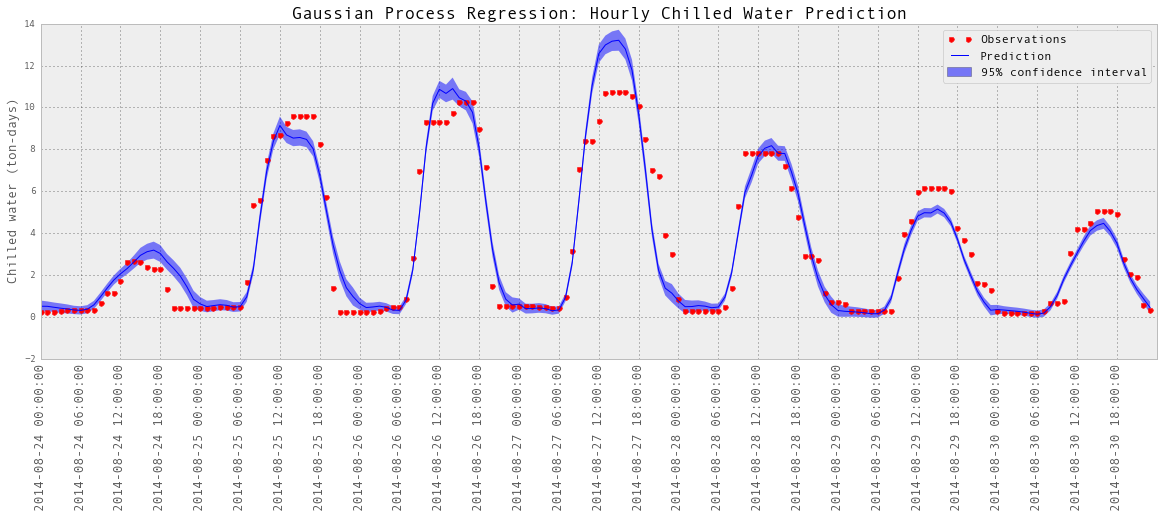

In [237]:
subset = results_hourlyChilledWater['2014-08-24':'2014-08-30']
testY = subset['chilledWater-TonDays']
predictedY = subset['predictedY']
sigma = subset['sigma']

plotGP(testY, predictedY, sigma)

plt.ylabel('Chilled water (ton-days)', fontsize = 13)
plt.title('Gaussian Process Regression: Hourly Chilled Water Prediction', fontsize = 17)
plt.legend(loc='upper right')
plt.xlim([0, len(testY)])
#plt.ylim([1000,8000])

xTickLabels = subset.index[np.arange(0,len(subset.index),6)]
ax = plt.gca()
ax.set_xticks(np.arange(0, len(subset), 6))
ax.set_xticklabels(labels = xTickLabels, fontsize = 13, rotation = 90)
plt.show()

#### Train and test all hourly data

In [ ]:
trainStart = '2012-01'
trainEnd = '2013-06'
testStart = '2013-07'
testEnd = '2014-10'


predictedElectricity = getPredictedElectricity(trainStart, trainEnd, testStart, testEnd)   

# Chilled water
hourlyChilledWaterWithMoreFeatures = hourlyChilledWaterWithFeatures.join(predictedElectricity, how = 'inner')
hourlyChilledWaterWithMoreFeatures = addHourlyTimeFeatures(hourlyChilledWaterWithMoreFeatures)

df_hourlyChilledWater = hourlyChilledWaterWithMoreFeatures[['hour', 'cosHour', 'weekday', 'day', 'week', 'occupancy', 'T-C', 
                                                        'humidityRatio-kg/kg', 'predictedElectricity', 'chilledWater-TonDays']]

df = df_hourlyChilledWater;

trainX_hourlyChilledWater, trainY_hourlyChilledWater, testX_hourlyChilledWater, testY_hourlyChilledWater, \
    testSet_hourlyChilledWater = setTrainTestSets(df, trainStart, trainEnd, testStart, testEnd, 9) 

gp_hourlyChilledWater, results_hourlyChilledWater = predictAll(0.011, 0.01, trainX_hourlyChilledWater, trainY_hourlyChilledWater, 
                                  testX_hourlyChilledWater, testY_hourlyChilledWater, testSet_hourlyChilledWater)

results_hourlyChilledWater.to_excel('Data/results_allHourlyChilledWater.xlsx')

> Final accuracy for hourly chilled water prediction.

Test score R2: 0.887195665411


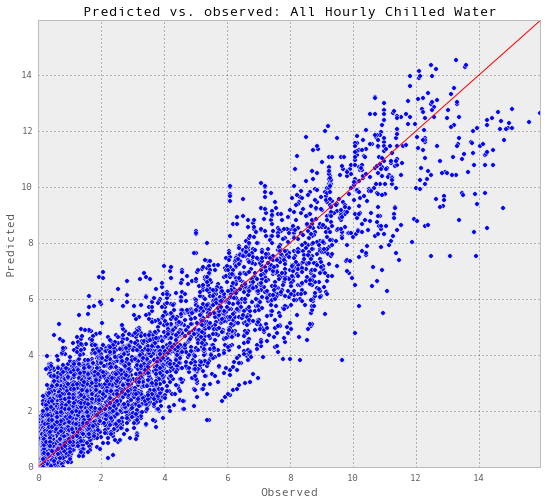

In [33]:
results_allHourlyChilledWater = pd.read_excel('Data/results_allHourlyChilledWater.xlsx')

plotR2(results_allHourlyChilledWater, 'chilledWater-TonDays', 'All Hourly Chilled Water')

### Hourly Steam

> Get the training/validation and test set. The dataframe shows the features and the target.

In [34]:
trainStart = '2012-01'
trainEnd = '2012-03'
testStart = '2014-01'
testEnd = '2014-03'    

predictedElectricity = getPredictedElectricity(trainStart, trainEnd, testStart, testEnd)   
hourlySteamWithMoreFeatures = hourlySteamWithFeatures.join(predictedElectricity, how = 'inner')

hourlySteamWithMoreFeatures = addHourlyTimeFeatures(hourlySteamWithMoreFeatures)

df_hourlySteam = hourlySteamWithMoreFeatures[['hour', 'cosHour', 'weekday', 'day', 'week', 'occupancy', 'T-C', 
                                                        'humidityRatio-kg/kg', 'predictedElectricity', 'steam-LBS']]


df = df_hourlySteam;

trainX_hourlySteam, trainY_hourlySteam, testX_hourlySteam, testY_hourlySteam, \
    testSet_hourlySteam = setTrainTestSets(df, trainStart, trainEnd, testStart, testEnd, 9) 


df_hourlySteam.head()

hour   cosHour  weekday  day  week  occupancy  T-C  \
2012-01-01 01:00:00     1  0.866025        6    1    52          0    4   
2012-01-01 02:00:00     2  0.965926        6    1    52          0    4   
2012-01-01 03:00:00     3  1.000000        6    1    52          0    5   
2012-01-01 04:00:00     4  0.965926        6    1    52          0    6   
2012-01-01 05:00:00     5  0.866025        6    1    52          0    4   

                     humidityRatio-kg/kg  predictedElectricity    steam-LBS  
2012-01-01 01:00:00             0.004396            117.502720   513.102214  
2012-01-01 02:00:00             0.004391            114.720226  1353.371311  
2012-01-01 03:00:00             0.004380            113.079503  1494.904514  
2012-01-01 04:00:00             0.004401            112.428146   490.090061  
2012-01-01 05:00:00             0.004382            113.892620   473.258464

> Cross validation to get input parameters

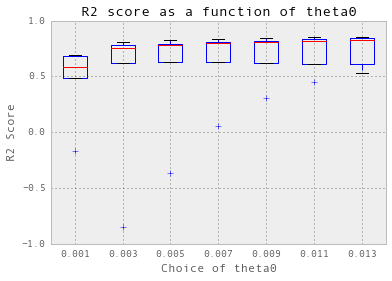

In [232]:
nugget = 0.01
theta = np.arange(0.001, 0.014, 0.002)
crossValidation(theta, nugget, 5, trainX_hourlySteam, trainY_hourlySteam)

> Predict, calculate accuracy and visualize

Train score R2: 0.844826486064
Test score R2: 0.570427290315


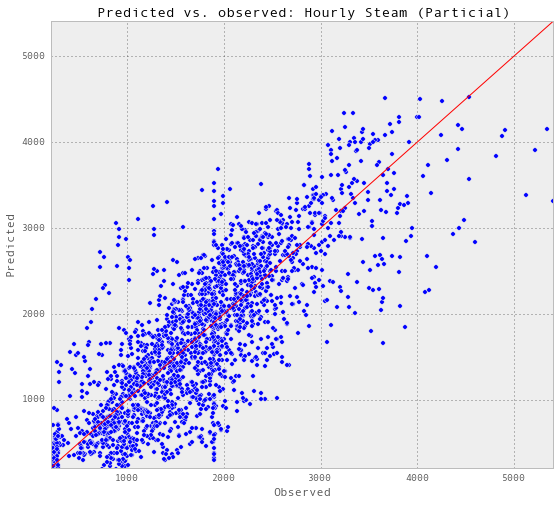

In [35]:
gp_hourlySteam, results_hourlySteam = predictAll(0.007, 0.01, trainX_hourlySteam, trainY_hourlySteam, 
                                  testX_hourlySteam, testY_hourlySteam, testSet_hourlySteam, 'Hourly Steam (Particial)')

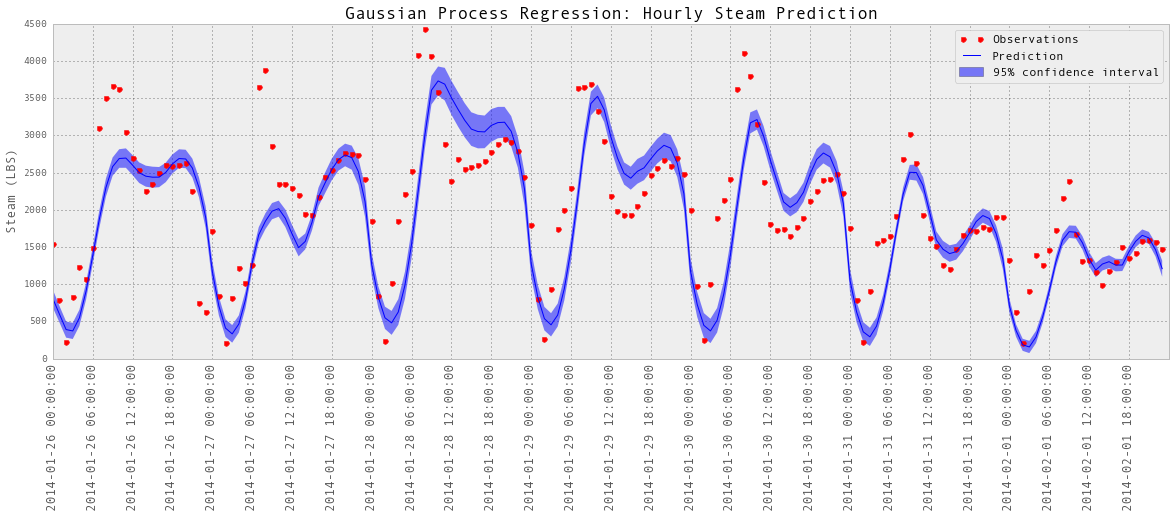

In [251]:
subset = results_hourlySteam['2014-01-26':'2014-02-01']
testY = subset['steam-LBS']
predictedY = subset['predictedY']
sigma = subset['sigma']

plotGP(testY, predictedY, sigma)

plt.ylabel('Steam (LBS)', fontsize = 13)
plt.title('Gaussian Process Regression: Hourly Steam Prediction', fontsize = 17)
plt.legend(loc='upper right')
plt.xlim([0, len(testY)])

xTickLabels = subset.index[np.arange(0,len(subset.index),6)]
ax = plt.gca()
ax.set_xticks(np.arange(0, len(subset), 6))
ax.set_xticklabels(labels = xTickLabels, fontsize = 13, rotation = 90)
plt.show()

#### Try train and test all hourly steam

In [ ]:
trainStart = '2012-01'
trainEnd = '2013-06'
testStart = '2013-07'
testEnd = '2014-10'


predictedElectricity = getPredictedElectricity(trainStart, trainEnd, testStart, testEnd)   

# Steam
hourlySteamWithMoreFeatures = hourlySteamWithFeatures.join(predictedElectricity, how = 'inner')

hourlySteamWithMoreFeatures = addHourlyTimeFeatures(hourlySteamWithMoreFeatures)

df_hourlySteam = hourlySteamWithMoreFeatures[['hour', 'cosHour', 'weekday', 'day', 'week', 'occupancy', 'T-C', 
                                                        'humidityRatio-kg/kg', 'predictedElectricity', 'steam-LBS']]


df = df_hourlySteam;

trainX_hourlySteam, trainY_hourlySteam, testX_hourlySteam, testY_hourlySteam, \
    testSet_hourlySteam = setTrainTestSets(df, trainStart, trainEnd, testStart, testEnd, 9) 
    
gp_hourlySteam, results_hourlySteam = predictAll(0.007, 0.01, trainX_hourlySteam, trainY_hourlySteam, 
                                  testX_hourlySteam, testY_hourlySteam, testSet_hourlySteam)

results_hourlySteam.to_excel('Data/results_allHourlySteam.xlsx')

> Final accuracy for hourly steam prediction.

Test score R2: 0.84405417838


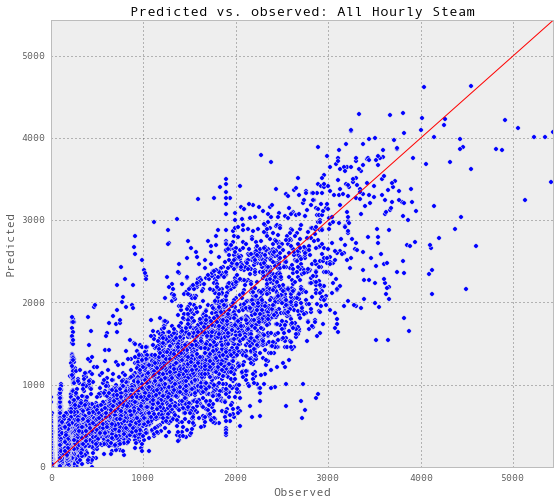

In [36]:
results_allHourlySteam = pd.read_excel('Data/results_allHourlySteam.xlsx')

plotR2(results_allHourlySteam, 'steam-LBS', 'All Hourly Steam')

The hourly prediction is not as good as daily. But still, we can get R2 score around 0.85.

### Summary

The overall performance of Gaussian Process regression is quite good for this task. The advantage of GP is that it provides uncertainty range of predictions. The disavantage is that it is computationally expensive for large data sets.